# U-Net: nuclei segmentation 2

This is an implementation of a [Kaggle kernel](https://www.kaggle.com/c0conuts/unet-imagedatagenerator-lb-0-336/notebook) of a [U-net](https://arxiv.org/abs/1505.04597).

Changes:
* added model time elapsed with timeit
* modelling:
    * batch_size=100
    * epochs=3
* data augmentation:
    * shear_range=0.3
    * rotation_range=90
    * zoom_range=0.4
    * width_shift_range=0.3
    * height_shift_range=0.3
    * fill_mode='reflect'

Ideas:
* add watershed transform to mask image

In [119]:
%pwd

'/home/ubuntu/nuclei_segmentation/notebooks'

In [120]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

In [121]:
from tqdm import tqdm
from datetime import datetime 
from itertools import chain

from skimage.io import imread, imsave, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [122]:
from utils.imaging import get_path, get_image_ids, label_mask, segmented_annotate
from utils.evaluate import keras_mean_iou, submit_kaggle
from utils import run_length_encoding

In [123]:
%matplotlib inline
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

get model name form notebook name using javascript

In [124]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [125]:
notebook_name = os.path.splitext(os.path.basename(nb_name))[0]

model_name = notebook_name + '.h5'
model_path = get_path('models') + model_name

submission_name = notebook_name + '.csv'
submission_path = get_path('submission') + submission_name

### 0. U-Net Parameters

In [126]:
seed = 42

# model parameters
BATCH_SIZE = 100 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3
TRAIN_PATH = get_path('data_train_1')
TEST_PATH = get_path('data_test_1')

### 1. Preprocess data

In [127]:
# Get train and test IDs
train_ids = get_image_ids(TRAIN_PATH)
test_ids = get_image_ids(TEST_PATH)
np.random.seed(10)

In [128]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:32<00:00,  7.25it/s]


In [129]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 75.75it/s]


### 2. Data augmentation

In [130]:
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.3, rotation_range=90, zoom_range=0.4, width_shift_range=0.3, height_shift_range=0.3, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.3, rotation_range=90, zoom_range=0.4, width_shift_range=0.3, height_shift_range=0.3, fill_mode='reflect')

In [131]:
# Keep the same seed for image and mask generators so they fit together
image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

In [132]:
# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

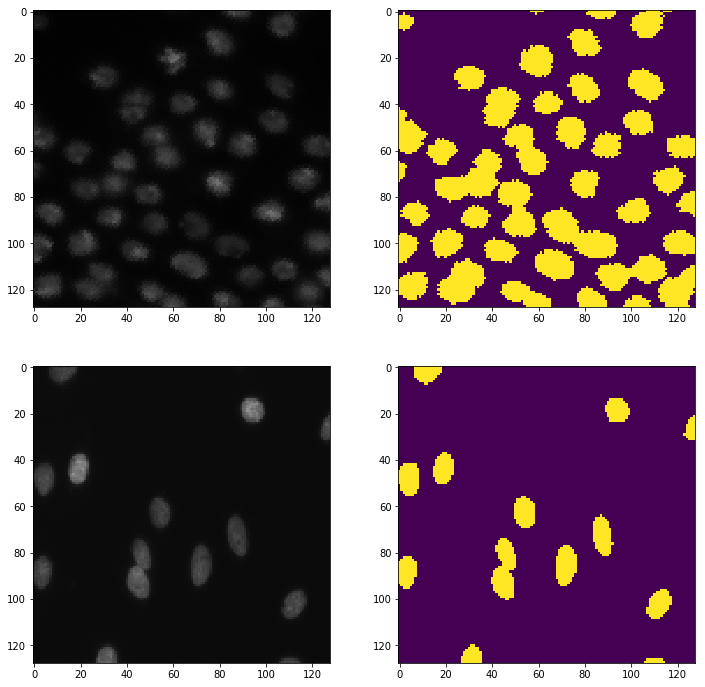

In [133]:
f, axarr = plt.subplots(2,2,figsize=(12,12))
axarr[0,0].imshow(x.next()[0].astype(np.uint8))
axarr[0,1].imshow(np.squeeze(y.next()[0].astype(np.uint8)))
axarr[1,0].imshow(x_val.next()[0].astype(np.uint8))
axarr[1,1].imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))

In [134]:
#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

### 3. Initialise U-Net model

In [135]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras_mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 128, 128, 16) 0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 

### 4. Train U-Net model

In [136]:
# Fit model
start_time = datetime.now() 

earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
results = model.fit_generator(train_generator,
                              validation_data=val_generator, 
                              validation_steps=10, 
                              steps_per_epoch=250,
                              epochs=5, 
                              callbacks=[earlystopper, checkpointer]
                             )

time_elapsed = datetime.now() - start_time 
print('\n Model training time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Epoch 1/5
249/250 [============================>.] - ETA: 0s - loss: 0.1759 - keras_mean_iou: 0.6000
Epoch 00001: val_loss improved from inf to 0.10701, saving model to /home/ubuntu/nuclei_segmentation/models/180227_wg_u_net_2.h5
250/250 [==============================] - 157s 629ms/step - loss: 0.1756 - keras_mean_iou: 0.6005 - val_loss: 0.1070 - val_keras_mean_iou: 0.7067
Epoch 2/5
249/250 [============================>.] - ETA: 0s - loss: 0.0989 - keras_mean_iou: 0.7399
Epoch 00002: val_loss improved from 0.10701 to 0.08703, saving model to /home/ubuntu/nuclei_segmentation/models/180227_wg_u_net_2.h5
250/250 [==============================] - 150s 600ms/step - loss: 0.0988 - keras_mean_iou: 0.7400 - val_loss: 0.0870 - val_keras_mean_iou: 0.7655
Epoch 3/5
249/250 [============================>.] - ETA: 0s - loss: 0.0859 - keras_mean_iou: 0.7799
Epoch 00003: val_loss improved from 0.08703 to 0.07610, saving model to /home/ubuntu/nuclei_segmentation/models/180227_wg_u_net_2.h5
250/250 

### 5. Predict with U-Net model

In [137]:
# Predict on train, val and test
model = load_model(model_path, custom_objects={'keras_mean_iou': keras_mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

65/65 [==============================] - 0s 2ms/step


In [138]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

sanity check on some training examples

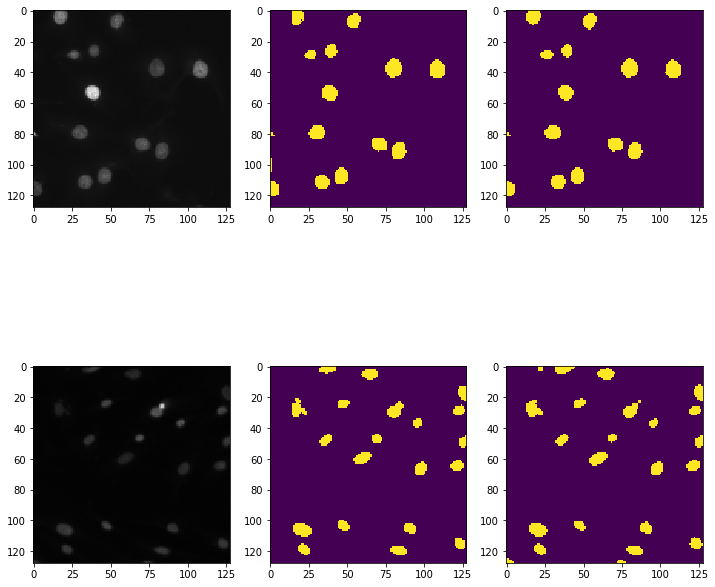

In [139]:
f, axarr = plt.subplots(2,3,figsize=(12,12))
ix1 = random.randint(0, len(preds_train_t))
ix2 = random.randint(0, len(preds_train_t))
axarr[0,0].imshow(X_train[ix1])
axarr[0,1].imshow(np.squeeze(Y_train[ix1]))
axarr[0,2].imshow(np.squeeze(preds_train_t[ix1]))
axarr[1,0].imshow(X_train[ix2])
axarr[1,1].imshow(np.squeeze(Y_train[ix2]))
axarr[1,2].imshow(np.squeeze(preds_train_t[ix2]))

### 7. Output image labels

Saving test labelled images

In [140]:
for idx, image_id in tqdm(enumerate(test_ids), total=len(test_ids)):
    mask = preds_test_upsampled[idx] > 0.5
    labels = label_mask(mask)
    imsave(get_path('output_test_1_lab_seg') + image_id + '.png', labels)

100%|██████████| 65/65 [00:00<00:00, 145.16it/s]


Saving test annotated images

In [141]:
segmented_annotate(image_type = 'test', stage_num = 1)

100%|██████████| 65/65 [00:27<00:00,  2.33it/s]


In [142]:
df = run_length_encoding.rle_images_in_dir(image_type = 'test', stage_num = 1)
df.to_csv(submission_path, index=False)

100%|██████████| 65/65 [00:07<00:00,  8.31it/s]


### 8. Kaggle submit

In [143]:
message = "batch size of 100 and 5 epochs"

In [144]:
submit_string = submit_kaggle(notebook_name, submission_path, message)

In [145]:
!$submit_string

0.294
